## Description

**Dataset**

Each example is a random pair of MNIST digits placed at random positions within a large black image, with the target label of the sum of the MNIST digits.

**Model**

A recurrent attention model that looks at the downsampled image and selects 2 high-res patches to look at before making a prediction.



## Install

In [0]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2

def show_image(image):
  image = image.squeeze()
  plt.imshow(image, cmap='gray')
  plt.axis('off')

## Config

In [0]:
debug = False
device = th.device('cuda' if th.cuda.is_available() and not debug else 'cpu')
print(f'Using {device}')

# Synthetic dataset
width = 128
height = 128
num_images = 50000
num_images_test = 10000
tiles_per_image = 1
num_classes = 1 + 9 * tiles_per_image  # [0, ..., 9 * n]

# ImageWorld
window_size = 32

num_epochs = 10
batch_size = 32
learning_rate = 0.001

Using cuda


## Dataset: Synthetic MNIST

In [0]:
from rl.core.envs import synthetic_dataset

train_dataset = synthetic_dataset.MnistSyntheticDataset(
    width=width, height=height, num_images=num_images,
    tiles_per_image=tiles_per_image, train=True)

train_loader = th.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = synthetic_dataset.MnistSyntheticDataset(
    width=width, height=height, num_images=num_images_test,
    tiles_per_image=tiles_per_image, train=False)

test_loader = th.utils.data.DataLoader(
    dataset=test_dataset, batch_size= batch_size, shuffle=False)

## Environment

In [0]:
from rl.core.envs import image_world

train_env = image_world.ImageWorld(
    window_size=window_size,
    images=train_dataset.images,
    labels=train_dataset.labels,
    num_classes=num_classes)

test_env = image_world.ImageWorld(
    window_size=window_size,
    images=test_dataset.images,
    labels=test_dataset.labels,
    num_classes=num_classes)

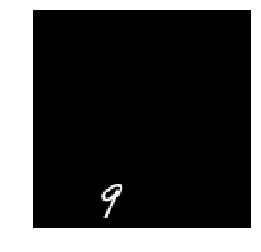

In [0]:
show_image(train_env.image)

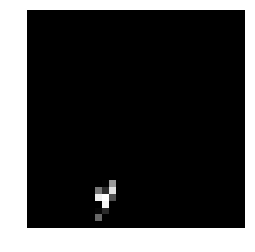

In [0]:
show_image(train_env.minimap)

In [0]:
train_env.label

9.0

## Model

In [0]:
# CNN over window
class CNN(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),

        nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        
        nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        
        nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(512),
        nn.ReLU(),
    )
    self.pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, output_size)
    
  def forward(self, x):
    out = self.convs(x)
    out = self.pooling(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out


## Algorithms

In [0]:
from rl.core.algs import plotter

def train(model, data_loader, name='', num_epochs=num_epochs):
  plot = plotter.Plotter(log_dir='/tmp/tensorboard/' + name)
  
  # Loss and optimizer.
  loss_fn = nn.CrossEntropyLoss()
  optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)


  num_steps = len(data_loader)
  for epoch in range(num_epochs):
    for step, (images, labels) in enumerate(data_loader):
      images, labels = images.to(device), labels.to(device, dtype=th.long)

      # Forward
      outputs = model(images)
      loss = loss_fn(outputs, labels)

      # Backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if step % 100 == 0:
        plot.add_data('loss', epoch * num_steps + step,
                         loss.detach().cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {loss.item():.4}')

  plot.line_plot()
  

def eval(model, data_loader):
  with th.no_grad():
    correct, total = 0, 0
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device, dtype=th.long)
      outputs = model(images)
      _, predicted = th.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy of model on {total} images: {100 * accuracy:0.2f}%')

## Baseline: CNN over minimaps

Not expected to work well.

In [0]:
mini_train_ds = th.utils.data.TensorDataset(
    th.Tensor(train_env._images_mini), th.Tensor(train_env._labels))
mini_train_loader = th.utils.data.DataLoader(
    dataset=mini_train_ds, batch_size=batch_size, shuffle=True)


mini_test_ds = th.utils.data.TensorDataset(
    th.Tensor(test_env._images_mini), th.Tensor(test_env._labels))
mini_test_loader = th.utils.data.DataLoader(
    dataset=mini_test_ds, batch_size=batch_size, shuffle=True)

Epoch [1/20], Loss: 0.5902
Epoch [2/20], Loss: 0.745
Epoch [3/20], Loss: 0.4702
Epoch [4/20], Loss: 0.376
Epoch [5/20], Loss: 0.4306
Epoch [6/20], Loss: 0.2725
Epoch [7/20], Loss: 0.2321
Epoch [8/20], Loss: 0.6395
Epoch [9/20], Loss: 0.5306
Epoch [10/20], Loss: 0.2404
Epoch [11/20], Loss: 0.2366
Epoch [12/20], Loss: 0.05824
Epoch [13/20], Loss: 0.2489
Epoch [14/20], Loss: 0.02324
Epoch [15/20], Loss: 0.2097
Epoch [16/20], Loss: 0.05279
Epoch [17/20], Loss: 0.1115
Epoch [18/20], Loss: 0.01116
Epoch [19/20], Loss: 0.08963
Epoch [20/20], Loss: 0.2319


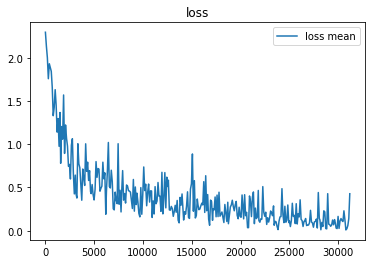

In [0]:
baseline_model = CNN(num_classes).to(device)
train(baseline_model, mini_train_loader, 'synthetic_mnist_cnn_mini',
      num_epochs=20)


In [0]:
eval(baseline_model, mini_test_loader)

Accuracy of model on 10000 images: 85.37%


In [0]:
eval(baseline_model, mini_train_loader)

Accuracy of model on 50000 images: 96.62%


## Policy: fixed length

In [0]:
# RNN Controller
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    """
    Args:
      x: input tensor, shaped [seq_len, batch_size, input_size]
    """
    if self.h_n is None:
      # Set initial hidden and cell states.
      self.h_n = th.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
      self.c_n = th.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
    
    # Forward propagate LSTM.
    # out shape (seq_len, batch_size, hid_size)
    out, (self.h_n, self.c_n) = self.lstm(x, (self.h_n, self.c_n))
    
    # Decode the hidden state of the last time step.
    out = self.fc(out[-1, :, :])
    return out
    
  def reset(self):
    self.h_n, self.c_n = None, None
  
  def step(self, x):
    """
    Args:
      x: input tensor, shaped [batch_size, input_size]
    """
    return forward(x.unsqueeze(dim=0))

In [0]:
minimap_cnn = CNN(output_size=2)  # (x, y)
class_cnn = CNN(num_classes)



## Train

## Test

## Visualize

In [0]:
with th.no_grad():
  images, labels = next(iter(test_loader))
  images, labels = images.to(device), labels.to(device, dtype=th.long)
  preds = model(images)

tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor([-65.1824, -17.0377, -18.4109, -23.8195, -17.5708, -14.8207, -17.6504,
         13.5137,  -7.6158, -12.6516, -13.4251, -16.3913, -18.0062,  -9.7191,
        -31.7705, -22.9673, -44.8392, -66.1163, -88.2574], device='cuda:0')


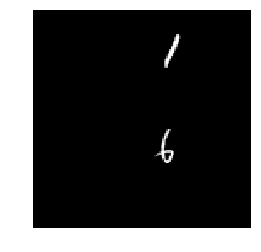

In [0]:
show_image(images[0].cpu())
print(labels[0], th.argmax(preds[0]))
print(preds[0])

tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor([-69.5024, -49.4482, -36.4089, -27.7180, -23.8961, -16.9660, -12.2554,
        -14.4462, -15.4553,  -9.9069,  -8.2601,  10.7134,  -6.8387,  -5.3839,
        -16.5228, -12.9464,  -6.7946,  -5.1531,  -6.4700], device='cuda:0')


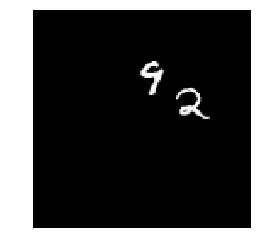

In [0]:
show_image(images[-1].cpu())
print(labels[-1], th.argmax(preds[-1]))
print(preds[-1])

## Save model

In [0]:
th.save(model.state_dict(), '/tmp/synthetic_mnist_conv.ckpt')